# Why need Data Augmentation

Our neural network is only as good as the data it was trained on

Based on our initial dataset of 1000 images per class there are two ways to approach in helping train our model to generalize on unseen data ([source](https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/))

1) Using `dataset generation` and expanding an existing dataset 

![image info](../picture_ref/data_aug_inplace.png.webp)

2) Using `ImageDataGenerator to do on-the-fly data augmentation`, a non-additive approach of randomly transforming images by: 
    - Rotation 
    - Flipping
    - Change of brightness
    - Zooming
    - Shifting 

![image info](../picture_ref/data_generation.webp)

`Step 2` is more appropriate given the time we have to train the model, especially using it on VGG16 which takes alot of computing power and time. Hence, using step to artificially transform data as it trains the model will be more efficient for this project.

# Import Libraries 

In [1]:
# #to disable GPU
# import os, datetime
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0.2
GPU is available


In [65]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import layers
from matplotlib.pyplot import imread, imshow, subplots, show
from skimage.filters import gaussian
import skimage

import itertools
import os
import cv2
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter(action= 'ignore', category=FutureWarning)
%matplotlib inline

pd.set_option('display.max_colwidth', None)

# Loading Images

Based on previous journal, we will continue to use dataset_unbalanced as it gives the highest accuracy score. 

In [4]:
# establish train and test path 

train_path = '../data/dataset_unbalanced/train/'
test_path = '../data/dataset_unbalanced/val/'

In [5]:
# this cel is to generate classes 

# getting dir for all clasess in train path 
folders = glob.glob(train_path + '*')

# generate Dataframe for train list 
train_list = pd.DataFrame(glob.glob(train_path + '*')).rename(columns = {0: 'name'})

# generate ordinal categories for y
train_list['class_name'] = train_list.name.apply(lambda x: x.split("\\")[1])

# generate unique list of vegetables. Should have 22 classes. 
classes = train_list['class_name'].unique().tolist()
print(f'Number of classes: {len(classes)}')

Number of classes: 22


In [6]:
# print out classes 
for num,name in enumerate(classes):
    print(num,name)

0 Baby_Chyesim
1 Bean
2 Bitter_Gourd
3 Bottle_Gourd
4 Brinjal
5 Broccoli
6 Cabbage
7 Capsicum
8 Carrot
9 Cauliflower
10 Celery
11 Coriander
12 Cucumber
13 Daun_Sup
14 Kailan
15 Kangkong
16 Parsley
17 Potato
18 Pumpkin
19 Radish
20 Sharp_Spinach
21 Tomato


(224, 224, 3)


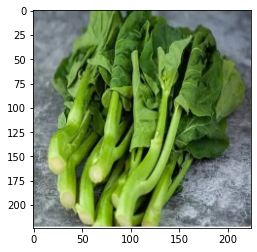

In [7]:
# getting one image out as reference 
img_path='../data/dataset/test/kailan4.jpg'
img_arr=cv2.imread(img_path)
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
img_arr=img_arr/255
img_arr=cv2.resize(img_arr, (224,224))
print(img_arr.shape)
plt.imshow(img_arr);

In [8]:
# create function that helps to visualise difference between original and augmented
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [9]:
# create function that helps plot out images and its augmented version from datagenerator
def plot(data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    show()
    
image = imread(img_path)

# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


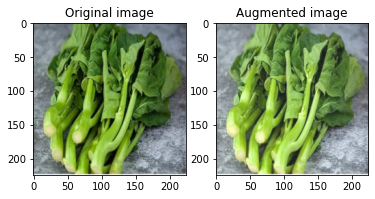

In [10]:
# applying adjustment: brightness 
bright = tf.image.adjust_brightness(img_arr, 0.1)
visualize(img_arr, bright)

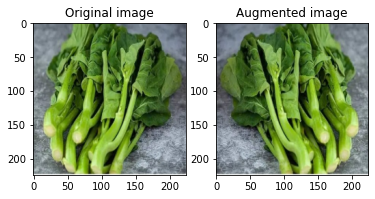

In [11]:
# applying adjustment: flip_right
flipped = tf.image.flip_left_right(img_arr)
visualize(img_arr, flipped)

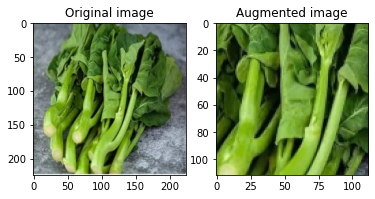

In [12]:
# applying adjustment: cropping
cropped = tf.image.central_crop(img_arr, central_fraction=0.5)
visualize(img_arr, cropped)

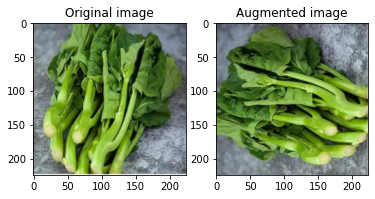

In [13]:
# applying adjustment: rotation
rotated = tf.image.rot90(img_arr)
visualize(img_arr, rotated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


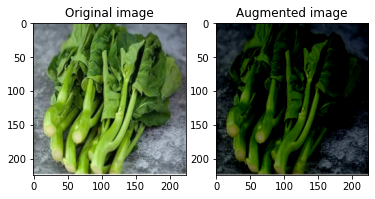

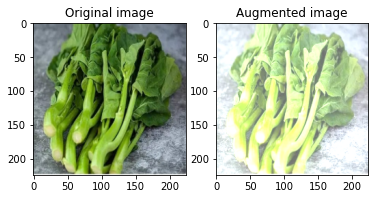

In [14]:
# applying adjustment: random brightness
for i in range(2):
  stateless_random_brightness = tf.image.random_brightness(
      img_arr, max_delta=0.95, seed = 51)
  visualize(img_arr, stateless_random_brightness)

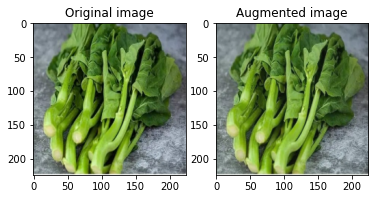

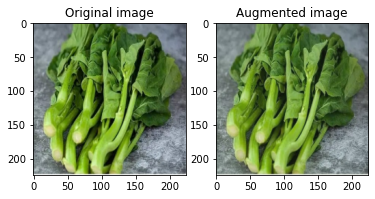

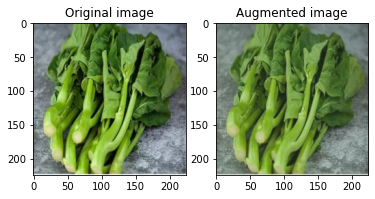

In [15]:
# applying adjustment: random contrast 
for i in range(3):
  stateless_random_brightness = tf.image.random_contrast(
      img_arr, lower = 0.3, upper = 0.95, seed = 42)
  visualize(img_arr, stateless_random_brightness)

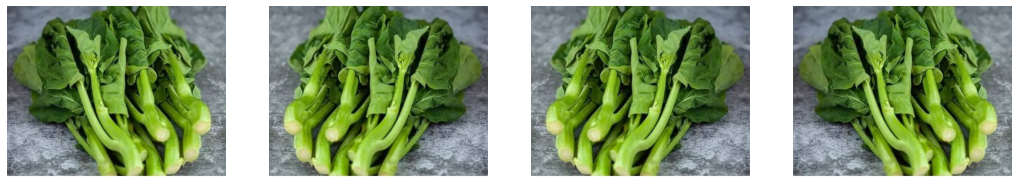

In [16]:
# applying adjustment: horizontal flip 
data_generator = ImageDataGenerator(horizontal_flip=True)
plot(data_generator)

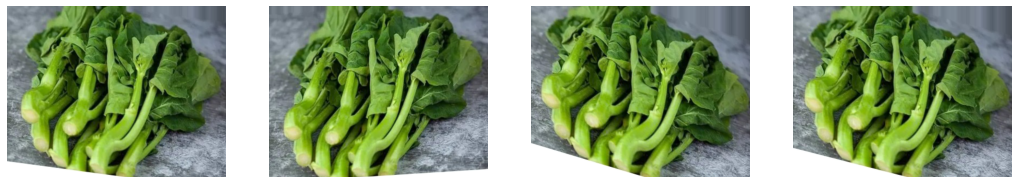

In [18]:
# applying adjustment: shear range
data_generator = ImageDataGenerator(shear_range=30.0)
plot(data_generator)

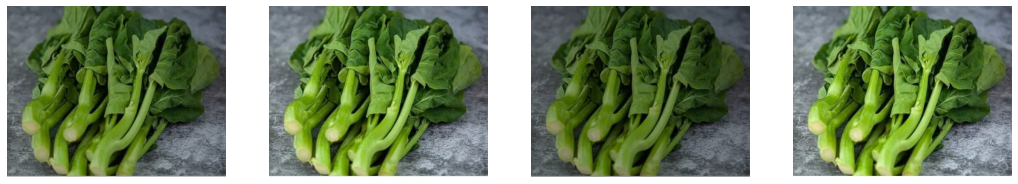

In [19]:
# applying adjustment: brightness range using image data generator 
data_generator = ImageDataGenerator(brightness_range=(0.6, 1.2))
plot(data_generator)

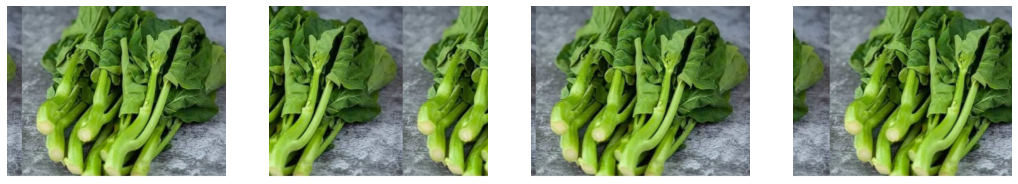

In [20]:
# applying adjustment: width shift range (imagedatagenerator)
# used more for highlight side features. Do not need for this problem statement as most pictures are centered. 

data_generator = ImageDataGenerator(width_shift_range=0.5, fill_mode='wrap')
plot(data_generator)

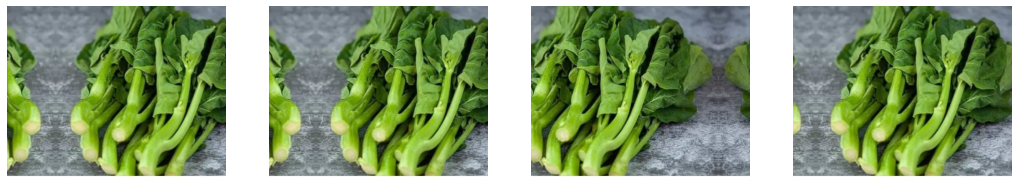

In [21]:
# applying adjustment: width shift range (imagedatagenerator)
# used more for highlight side features. Do not need for this problem statement as most pictures are centered. 
data_generator = ImageDataGenerator(width_shift_range=0.5, fill_mode='reflect')
plot(data_generator)

# Define functions

In [23]:
# define a function that creates simple, constant cnn model to do iterations 

def create_cnn():

    # Instantiate a CNN.
    cnn_model = Sequential()

    # Add a convolutional layer.
    cnn_model.add(Conv2D(filters=22,             # number of filters
                        kernel_size=(3,3),      # height/width of filter
                        activation='relu',      # activation function 
                        padding = 'same',
                        input_shape=(224,224,3))) # shape of input (image)

    # Add a pooling layer.
    cnn_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

    # Add another convolutional layer.
    cnn_model.add(Conv2D(44,
                        kernel_size=(3,3),
                        padding = 'same',
                        activation='relu'))

    # Add another pooling layer.
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    # We have to remember to flatten to go from the "box" to the vertical line of nodes!
    cnn_model.add(Flatten())

    # Add a densely-connected layer with 64 neurons.
    cnn_model.add(Dense(88, activation='relu'))

    # Let's try to avoid overfitting!
    cnn_model.add(Dropout(0.2))

    # Add a densely-connected layer with 44 neurons.
    cnn_model.add(Dense(44, activation='relu'))

    # Let's try to avoid overfitting!
    cnn_model.add(Dropout(0.2))

    # Add a final layer 
    cnn_model.add(Dense(len(classes), activation='softmax'))

    # Compile model
    cnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

    return cnn_model

In [24]:
# define function to create model and run, output will be history and model

def run_model(train_batch,test_batch,name_of_iteration, epochs):
    #isntantiate model
    model = create_cnn()

    checkpoint_path = "../data_augmentation/" + name_of_iteration + "cp-{epoch:04d}.ckpt"

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1,
                                                    )

    # Train the model with the new callback
    hist = model.fit(train_batch, 
                    epochs=epochs,
                    validation_data=test_batch,
                    steps_per_epoch = len(train_batch),
                    validation_steps = len(test_batch),
                    callbacks=[cp_callback])  # Pass callback to training
    
    #saving history
    hist_name = '../history_augmentation/hist_' + name_of_iteration + '.npy'
    np.save(hist_name,hist.history)

    return hist, model

In [25]:
# define function that plots out history for accuracy and validation loss 

def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss= hist.history['loss']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [26]:
# define function that plots out history from saved checkpoint 
def plot_history_from_saved_ckpt(hist):
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']

    loss= hist['loss']
    val_loss = hist['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [27]:
# define function that plots images in series 
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize = (30,30))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Data Generation

In [31]:
#Instantiate test batches 
test_batches = ImageDataGenerator(
        rescale = 1./225,
    ).flow_from_directory(directory = test_path, target_size = (224,224), class_mode = 'categorical',batch_size = 32)

#Instantiate test batches 
train_batches = ImageDataGenerator(
        rescale = 1./225,
    ).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical',batch_size = 32)    

Found 10444 images belonging to 22 classes.
Found 52091 images belonging to 22 classes.


# Deep learning: Classification Modelling

The idea is to get an initial benchmark on model's performance, and incrementally try different techniques to see whether they improve the performance

## 1st Model - Initial base model with CNN (No Data Augmentation)

We will be using base model created from Notebook #1

The base model consist of

- **Input layers** Conv2D layer (with 22 filters) paired with a Maxpooling
- **Second layer** Another Conv2D(with 44 filter) + Max pooling to further extract features 
- **Fully-connected nerual network layers** of Flatten layer and added **two more conv2D layers** (with 88,44 filters) fitted with Dropout to prevent overfitting follwed by Dense layer of class: 22 nodes for multi-class classification.

In [32]:
# defining fucntion that creates base model and change epoch to 10 to allow maximised fitting 
def create_run_CNN_model(train_batch, test_batch):

    # Instantiate a CNN.
    cnn_model = Sequential()

    # Add a convolutional layer.
    cnn_model.add(Conv2D(filters=22,             # number of filters
                        kernel_size=(3,3),      # height/width of filter
                        activation='relu',      # activation function 
                        padding = 'same',
                        input_shape=(224,224,3))) # shape of input (image)

    # Add a pooling layer.
    cnn_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

    # Add another convolutional layer.
    cnn_model.add(Conv2D(44,
                        kernel_size=(3,3),
                        padding = 'same',
                        activation='relu'))

    # Add another pooling layer.
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    # We have to remember to flatten to go from the "box" to the vertical line of nodes!
    cnn_model.add(Flatten())

    # Add a densely-connected layer with 88 neurons.
    cnn_model.add(Dense(88, activation='relu'))

    # Let's try to avoid overfitting!
    cnn_model.add(Dropout(0.2))

    # Add a densely-connected layer with 44 neurons.
    cnn_model.add(Dense(44, activation='relu'))

    # Let's try to avoid overfitting!
    cnn_model.add(Dropout(0.2))

    # Add a final layer 
    cnn_model.add(Dense(len(classes), activation='softmax'))

    # Compile model
    cnn_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    checkpoint_path = "training_CNN/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1,
                                                    )  
    # Fit model on training data
    history = cnn_model.fit_generator(train_batch,
                            validation_data = test_batch,
                            epochs=10,
                            verbose=1,
                            steps_per_epoch = len(train_batch),
                            validation_steps = len(test_batch),
                            callbacks = [cp_callback],
                            )


    return history, cnn_model

In [33]:
# run cnn model on first iteration
history, cnn_model = create_run_CNN_model(train_batches, test_batches)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 1/10
1627/1628 [============================>.] - ETA: 0s - loss: 1.5664 - accuracy: 0.4955
Epoch 00001: saving model to training_CNN/cp-0001.ckpt
1628/1628 [==============================] - 152s 93ms/step - loss: 1.5659 - accuracy: 0.4957 - val_loss: 0.7323 - val_accuracy: 0.7821
Epoch 2/10
1627/1628 [============================>.] - ETA: 0s - loss: 0.7797 - accuracy: 0.7417
Epoch 00002: saving model to training_CNN/cp-0002.ckpt
1628/1628 [==============================] - 90s 55ms/step - loss: 0.7795 - accuracy: 0.7418 - val_loss: 0.5329 - val_accuracy: 0.8237
Epoch 3/10
1627/1628 [============================>.] - ETA: 0s - loss: 0.5342 - accuracy: 0.8241
Epoch 00003: saving model to training_CNN/cp-0003.ckpt
1628/1628 [==============================] - 88s 54ms/step - loss: 0.5341 - accuracy: 0.8241 - val_loss: 0.3964 - val_accuracy: 0.8742
Epoch 4/10
1626/1628 [==================

In [48]:
# summary table 
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 22)      616       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 22)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 44)      8756      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 44)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 137984)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 88)                12142680  
_________________________________________________________________
dropout_2 (Dropout)          (None, 88)               

In [34]:
# Saving the model as a saved model formant for possible use later.

cnn_model.save(f"../models/CNN_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/CNN_model\assets


In [35]:
# Saving the model as a h5 file for possible use later.

cnn_model.save(f"../models/CNN_model.h5")

In [36]:
# saving history for First CNN iteration 
np.save('hist_CNN.npy',history.history)

In [37]:
# load CNN and VGG model and tabulate accuracy scores 

# Create a new model instance
cnn_tabulate = create_cnn()
# Load the previously saved weights
cnn_tabulate.load_weights("../models/CNN_model.h5")

cnn_tabulate.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

# Re-evaluate the model
loss_cnn, acc_cnn = cnn_tabulate.evaluate(test_batches, verbose=2)
print("Restored model for CNN, accuracy: {:5.2f}%".format(100 * acc_cnn))

  ...
    to  
  ['...']
327/327 - 13s - loss: 0.3225 - accuracy: 0.9198
Restored model for CNN, accuracy: 91.98%


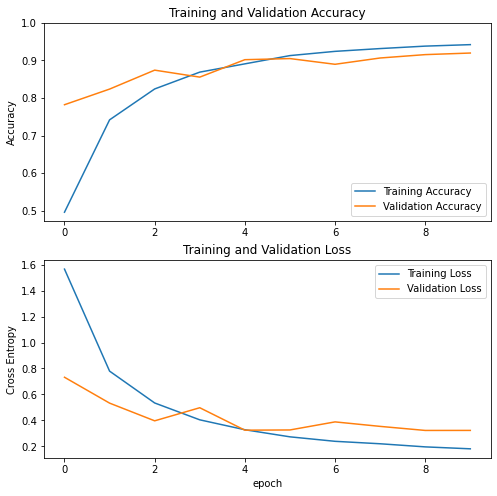

In [38]:
# reload CNN history
CNN_hist = np.load("hist_CNN.npy",allow_pickle=True).item()
plot_history_from_saved_ckpt(CNN_hist)

We can observe overfitting from epoch 5 onwards. Essentially, accuracy is still low, and data needs augmentation to prevent overfitting. 

In [74]:
# instantiate summary df

summary_df = pd.DataFrame(columns=['Model',
                                   'Preprocessing/Data Augmentaion',
                                   'Epoch',
                                   'Trainable Parameters',
                                   'Duration per epoch',
                                   'Train Loss',
                                   'Test Loss',
                                   'Train Accuracy',
                                   'Test Accuracy',
                                  ])

In [75]:
# input input values for base model 

summary_df.loc[1] = [
    "Base_Model: CNN",
    "No Data Augmentation",
    10,
    '12,156,958',
    '81s',
    CNN_hist['loss'][-1],
    CNN_hist['val_loss'][-1],
    CNN_hist['accuracy'][-1],
    CNN_hist['val_accuracy'][-1],
                    ]

In [76]:
summary_df

Model Preprocessing/Data Augmentaion Epoch Trainable Parameters  \
1  Base_Model: CNN           No Data Augmentation    10           12,156,958   

  Duration per epoch  Train Loss  Test Loss  Train Accuracy  Test Accuracy  
1                81s    0.180662   0.322523         0.94214       0.919763

# Data Augmention on CNN model

Reason why we chose the CNN base model was because it was the only model that was overfitted. Hence, i will like to explore the iterations of data augmentations that can help prevent this overfitting without impact too much on accuracy and loss.

## **Iteration #1**


- horizontal_flip = True
- vertical_flip = True
- shear_range = 30
- brightness_range = [0.6,1.2]



In [42]:
# apply data augmentation as follows below 
train_batch_1 = data_generator = ImageDataGenerator(
    rescale = 1./225,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 20,
    brightness_range = [0.6,1.2],
     ).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical', batch_size = 32)

Found 52091 images belonging to 22 classes.


In [ ]:
# obtain first batch of 32 images 
img,label = next(train_batch_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


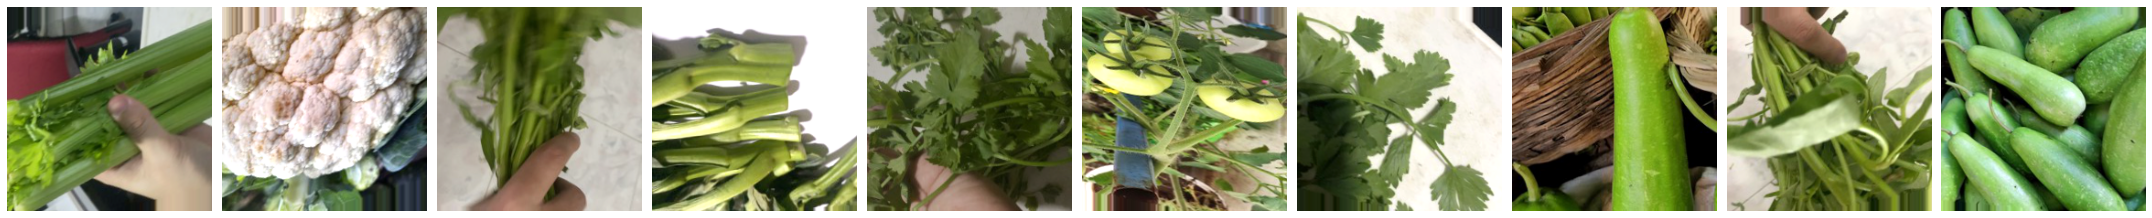

In [ ]:
# plot series of images 
plotImages(img)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 1/30
1627/1628 [============================>.] - ETA: 0s - loss: 2.1656 - accuracy: 0.2894
Epoch 00001: saving model to ../data_augmentation/interation_1cp-0001.ckpt
1628/1628 [==============================] - 550s 338ms/step - loss: 2.1653 - accuracy: 0.2895 - val_loss: 1.3173 - val_accuracy: 0.5483
Epoch 2/30
1627/1628 [============================>.] - ETA: 0s - loss: 1.4353 - accuracy: 0.5119
Epoch 00002: saving model to ../data_augmentation/interation_1cp-0002.ckpt
1628/1628 [==============================] - 570s 350ms/step - loss: 1.4352 - accuracy: 0.5119 - val_loss: 0.9283 - val_accuracy: 0.7001
Epoch 3/30
1627/1628 [============================>.] - ETA: 0s - loss: 1.1850 - accuracy: 0.5949
Epoch 00003: saving model to ../data_augmentation/interation_1cp-0003.ckpt
1628/1628 [==============================] - 569s 350ms/step - loss: 1.1850 - accuracy: 0.5949 - val_loss: 0.812

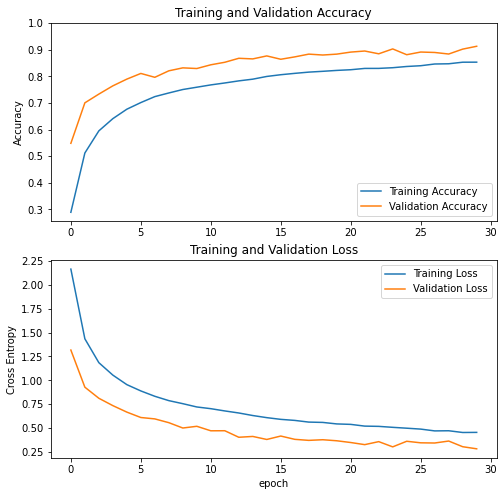

In [ ]:
# run 2nd iteration CNN Model with data augmentation #1 
hist_iter1, model_iter1 = run_model(train_batch_1, test_batches, 'interation_1', 30)

plot_history(hist_iter1)

In [57]:
# load model

model_iter1 = tf.keras.models.load_model('../models/CNN_model_iteration1.h5')

In [50]:
# check summary table 
model_iter1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 22)      616       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 22)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 44)      8756      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 44)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 137984)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 88)                12142680  
_________________________________________________________________
dropout_8 (Dropout)          (None, 88)               

In [58]:
# evaluate on test accuracy score 
model_iter1.evaluate(test_batches, verbose = 2)

  ...
    to  
  ['...']
327/327 - 13s - loss: 0.2819 - accuracy: 0.9124


[0.28191557578993137, 0.9123899]

In [43]:
# load history for 2nd iteration CNN model
hist_iter1 = np.load("../history_augmentation/hist_interation_1.npy",allow_pickle=True).item()

In [77]:
# input 2nd iteration CNN model data 

summary_df.loc[2] = [
    "CNN | Data Augmentation: Iteration 1",
    "Horizontal_flip, Vertical_flip,\
    Shear: 20, Brightness_range: [0.6,1.2]",
    30,
    '12,156,958',
    '557s',
    hist_iter1['loss'][-1],
    hist_iter1['val_loss'][-1],
    hist_iter1['accuracy'][-1],
    hist_iter1['val_accuracy'][-1],
                    ]

summary_df

Model  \
1                       Base_Model: CNN   
2  CNN | Data Augmentation: Iteration 1   

                                              Preprocessing/Data Augmentaion  \
1                                                       No Data Augmentation   
2  Horizontal_flip, Vertical_flip,    Shear: 20, Brightness_range: [0.6,1.2]   

  Epoch Trainable Parameters Duration per epoch  Train Loss  Test Loss  \
1    10           12,156,958                81s    0.180662   0.322523   
2    30           12,156,958               557s    0.454702   0.282578   

   Train Accuracy  Test Accuracy  
1        0.942140       0.919763  
2        0.852738       0.912390

In [ ]:
# Saving the model as a saved model formant for possible use later.

model_iter1.save(f"../models/CNN_model_iteration1")

# Saving the model as a h5 file for possible use later.

model_iter1.save(f"../models/CNN_model_iteration1.h5")

INFO:tensorflow:Assets written to: ../models/CNN_model_iteration1\assets


Iteration 1 has bigger variablitily than the base model. Hence, we see that the model is underfitted and took a significant amount of epoch to reach test comparable test accuracy with the base model. For iteration 2, we will add in Gaussian effect and remove vertical flip. 

## **Iteration #2**

- **Added Gaussian Effect** - Sigma set from (0,1) at random
- horizontal_flip = True
- shear_range = 30
- brightness_range = [0.6,1.2]

In [ ]:
# define function that gives blur effects on images with random values for sigma 
def give_gaussian_image(gray_img):
    gaussian_img = gaussian(gray_img, multichannel= False, sigma= np.random.uniform(0, 1))
    return gaussian_img

In [ ]:
# generate batches of randomly transformed images with augmentations below including Gaussian effect. 

train_batch_2 = ImageDataGenerator(
    rescale = 1./225,
    horizontal_flip = True,
    shear_range = 20,
    brightness_range = [0.6,1.2],
    preprocessing_function = give_gaussian_image
     ).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical', batch_size = 32)

Found 52091 images belonging to 22 classes.


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


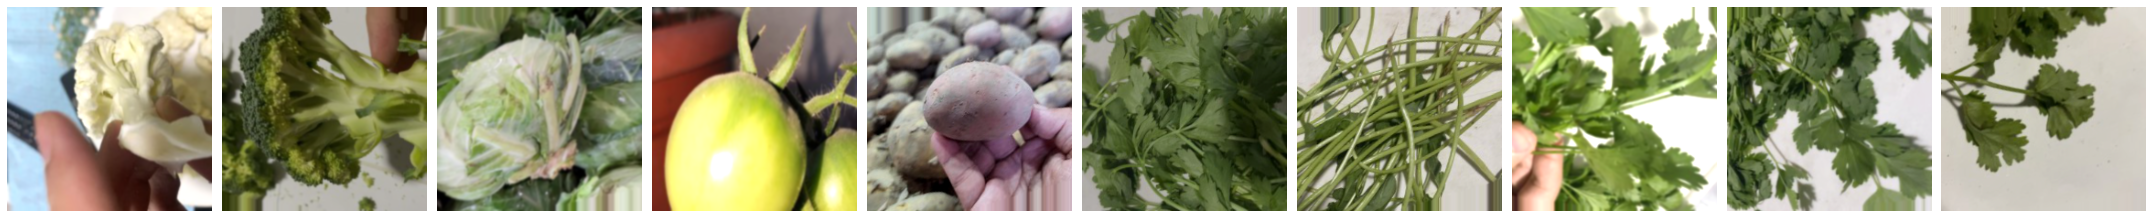

In [ ]:
# plot images 
img,label = next(train_batch_2)
plotImages(img)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1628 steps, validate for 327 steps
Epoch 1/30


C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


1627/1628 [============================>.] - ETA: 0s - loss: 1.9228 - accuracy: 0.3802
Epoch 00001: saving model to ../data_augmentation/interation_2cp-0001.ckpt
1628/1628 [==============================] - 686s 421ms/step - loss: 1.9224 - accuracy: 0.3804 - val_loss: 1.0694 - val_accuracy: 0.6449
Epoch 2/30
1627/1628 [============================>.] - ETA: 0s - loss: 1.2463 - accuracy: 0.5795
Epoch 00002: saving model to ../data_augmentation/interation_2cp-0002.ckpt
1628/1628 [==============================] - 619s 380ms/step - loss: 1.2464 - accuracy: 0.5795 - val_loss: 0.8266 - val_accuracy: 0.7272
Epoch 3/30
1627/1628 [============================>.] - ETA: 0s - loss: 1.0568 - accuracy: 0.6456
Epoch 00003: saving model to ../data_augmentation/interation_2cp-0003.ckpt
1628/1628 [==============================] - 620s 381ms/step - loss: 1.0566 - accuracy: 0.6456 - val_loss: 0.7393 - val_accuracy: 0.7580
Epoch 4/30
1627/1628 [============================>.] - ETA: 0s - loss: 0.9296 - 

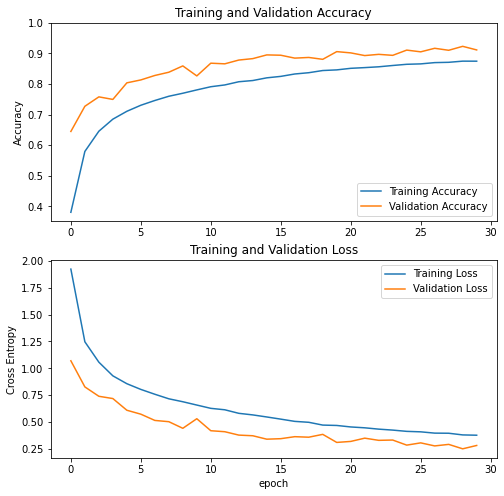

In [ ]:
# Run 3rd iteration model 

hist_iter2, model_iter2 = run_model(train_batch_2, test_batches, 'interation_2', 30)

plot_history(hist_iter2)

In [69]:
# load model for 3rd iteration model 
hist_iter2 = np.load("../history_augmentation/hist_interation_2.npy",allow_pickle=True).item()

In [78]:
# input model data 
summary_df.loc[3] = [
    "CNN | Data Augmentation: Iteration 2",
    "Gaussian Effect, Horizontal_flip,\
    Shear: 20, Brightness_range: [0.6,1.2]",
    30,
    '12,156,958',
    '621s',
    hist_iter2['loss'][-1],
    hist_iter2['val_loss'][-1],
    hist_iter2['accuracy'][-1],
    hist_iter2['val_accuracy'][-1],
                    ]

summary_df

Model  \
1                       Base_Model: CNN   
2  CNN | Data Augmentation: Iteration 1   
3  CNN | Data Augmentation: Iteration 2   

                                                Preprocessing/Data Augmentaion  \
1                                                         No Data Augmentation   
2    Horizontal_flip, Vertical_flip,    Shear: 20, Brightness_range: [0.6,1.2]   
3  Gaussian Effect, Horizontal_flip,    Shear: 20, Brightness_range: [0.6,1.2]   

  Epoch Trainable Parameters Duration per epoch  Train Loss  Test Loss  \
1    10           12,156,958                81s    0.180662   0.322523   
2    30           12,156,958               557s    0.454702   0.282578   
3    30           12,156,958               621s    0.377037   0.281738   

   Train Accuracy  Test Accuracy  
1        0.942140       0.919763  
2        0.852738       0.912390  
3        0.874796       0.911624

In [71]:
# save dataframe into csv file 
summary_df.to_csv('../logs/checkpoint/summary_df.csv')

The second iteration has higher training score, but the time taken per epoch that the CNN model with iteration 1 dataset. Because of its complexity, more memory space is needed to learn and maintain this model. Hence, i will choose iteration 1 as it is not overfitted, and has room of improvement if we were to apply transfer learning. 